In [73]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from pmdarima.arima import auto_arima

from models.tsnormalization import TimeNormalization

In [2]:
df = pd.read_csv('../data/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


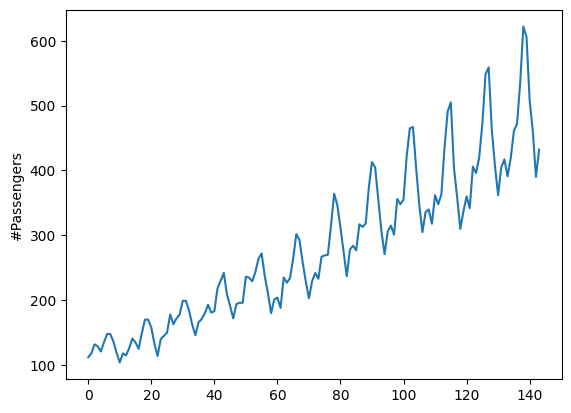

In [3]:
fig, ax = plt.subplots()

sns.lineplot(x=range(len(df)), y='#Passengers', data=df, ax=ax)
plt.show()

In [59]:
val_periods = 15
test_periods = 15
df_train = df.iloc[:-(val_periods + test_periods), :]
df_val = df.iloc[-(val_periods + test_periods):-test_periods, :]
df_test = df.iloc[-test_periods:, :]

print(f"{len(df)} = {len(df_train)} + {len(df_val)} + {len(df_test)}")

train_periods = len(df_train)

144 = 114 + 15 + 15


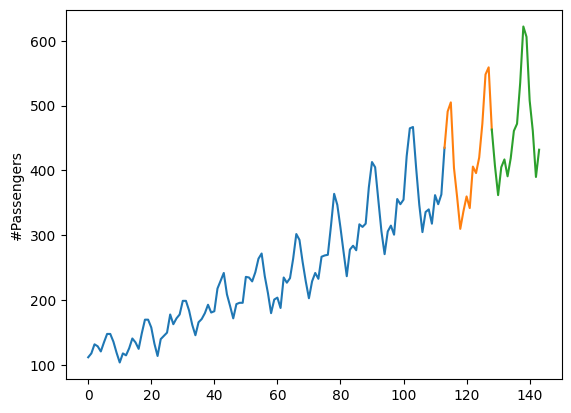

In [60]:
fig, ax = plt.subplots()

sns.lineplot(x=range(train_periods), y='#Passengers', data=df_train, ax=ax)
sns.lineplot(x=range(train_periods - 1, train_periods + val_periods), y='#Passengers', data=pd.concat([df_train.tail(1), df_val]), ax=ax)
sns.lineplot(
    x=range(
    train_periods + val_periods - 1, train_periods + val_periods + test_periods
    ),
    y='#Passengers',
    data=pd.concat([df_val.tail(1), df_test]),
    ax=ax
)
plt.show()

In [61]:
def transform_list(timeseries: list, input_timesteps: int, output_timesteps: int) -> tf.Tensor:
    len_timeseries = len(timeseries)
    input_timeseries = []
    output_timeseries = []
    for index in range(len_timeseries - (input_timesteps + output_timesteps - 1)):
        input_timeseries_item = timeseries[index:(index + input_timesteps)]
        output_timeseries_item = timeseries[(index + input_timesteps):(index + input_timesteps + output_timesteps)]
        input_timeseries.append(input_timeseries_item)
        output_timeseries.append(output_timeseries_item)
    return tf.convert_to_tensor(input_timeseries, dtype=tf.float32), tf.convert_to_tensor(output_timeseries, dtype=tf.float32)

In [62]:
periods = 14
buffer_size = 10000
batch_size = 16

def input_expand_dims(input_tensor, output_tensor):
    return tf.expand_dims(input_tensor, axis=-1), output_tensor


def convert_dataframe_to_tfdataset(dataframe, periods):
    dataset = tf.data.Dataset.from_tensor_slices(transform_list(dataframe['#Passengers'].tolist(), periods, 1))
    dataset = dataset.map(input_expand_dims)
    return dataset

dataset = convert_dataframe_to_tfdataset(df, periods=periods)
train_dataset = dataset.take(train_periods - periods).repeat().shuffle(buffer_size).batch(batch_size)
val_dataset = dataset.take(val_periods).batch(1000).cache()

In [68]:
input_layer = tf.keras.layers.Input(shape=[periods, 1])
x, mean, std = TimeNormalization()(input_layer)
x = tf.keras.layers.LSTM(
    units=100,
    return_sequences=True,
    activation='tanh'
)(x)
x = tf.keras.layers.LSTM(
    units=50,
    return_sequences=True,
    activation='tanh'
)(x)
x = tf.keras.layers.LSTM(
    units=25,
    return_sequences=False,
    activation='tanh'
)(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(units=1, activation='linear')(x)
output = std * x + mean

model = tf.keras.Model(input_layer, output)

model.compile(loss='mae', optimizer='adam')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
history = model.fit(
    train_dataset,
    epochs=1000,
    steps_per_epoch=100,
    callbacks=[early_stopping],
    validation_data=val_dataset,
    verbose=0
)

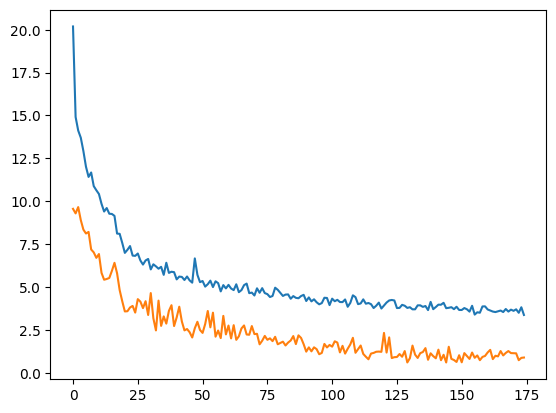

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [70]:
def long_term_predict(model, initial_data, timesteps=40):
    initial_shape = initial_data.shape
    new_data = initial_data
    step = 0
    while step < timesteps:
        input_data = new_data[:, -initial_shape[-2]:, :]
        simple_pred = model.predict(input_data, verbose=0)
        new_data = tf.concat([new_data, tf.cast(tf.expand_dims(simple_pred, axis=0), tf.float32)], axis=-2)
        step += 1
    return new_data[:, -timesteps:, :]

In [96]:
initial_data = tf.cast(tf.reshape(df_train.tail(periods)['#Passengers'].tolist(), [1, periods, 1]), tf.float32)
new_data_lstm = long_term_predict(model, initial_data, timesteps=val_periods + test_periods)

In [94]:
arima_model = auto_arima(
    df_train['#Passengers'], start_p=0, d=1, start_q=0,
    max_p=5, max_d=5, max_q=5,
    start_P=0, D=1, start_Q=0,
    max_P=5, max_D=5, max_Q=5, m=12,
    seasonal=True, error_action='warn', trace=True,
    suppress_warnings=True, stepwise=True,
    random_state=42, n_fits=500
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=749.666, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=746.994, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=747.670, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=746.999, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=748.475, Time=0.18 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=748.774, Time=0.18 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=747.301, Time=0.10 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=748.578, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=748.460, Time=0.10 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=747.923, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=747.379, Time=0.07 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=749.897, Time=0.26 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=748.975, Time=0.16 sec

Best model:  ARIMA(1,1,0)(1,1,0)[12]

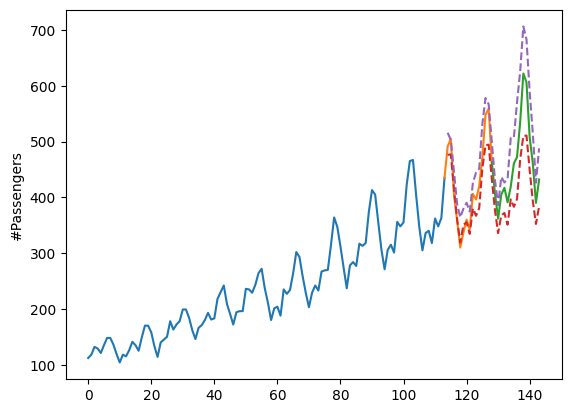

In [99]:
new_data_arima = arima_model.predict(n_periods=val_periods + test_periods)
fig, ax = plt.subplots()

sns.lineplot(x=range(train_periods), y='#Passengers', data=df_train, ax=ax)
sns.lineplot(x=range(train_periods - 1, train_periods + val_periods), y='#Passengers', data=pd.concat([df_train.tail(1), df_val]), ax=ax)
sns.lineplot(
    x=range(
    train_periods + val_periods - 1, train_periods + val_periods + test_periods
    ),
    y='#Passengers',
    data=pd.concat([df_val.tail(1), df_test]),
    ax=ax
)
sns.lineplot(
    x=range(train_periods, train_periods + val_periods + test_periods),
    y=new_data_arima,
    linestyle='dashed',
    ax=ax
)
sns.lineplot(
    x=range(train_periods, train_periods + val_periods + test_periods),
    y=new_data_lstm[0, :, 0],
    linestyle='dashed',
    ax=ax
)
plt.show()

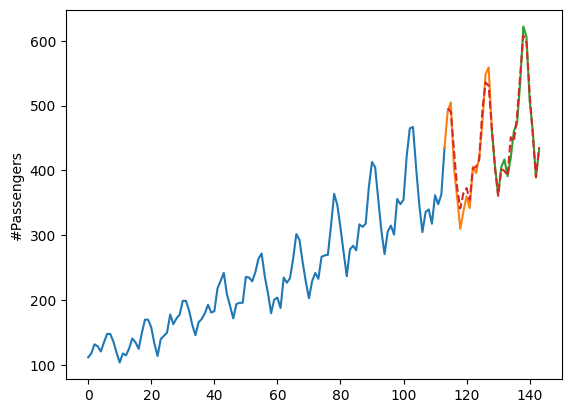

In [100]:
fig, ax = plt.subplots()

sns.lineplot(x=range(train_periods), y='#Passengers', data=df_train, ax=ax)
sns.lineplot(x=range(train_periods - 1, train_periods + val_periods), y='#Passengers', data=pd.concat([df_train.tail(1), df_val]), ax=ax)
sns.lineplot(
    x=range(
    train_periods + val_periods - 1, train_periods + val_periods + test_periods
    ),
    y='#Passengers',
    data=pd.concat([df_val.tail(1), df_test]),
    ax=ax
)

sns.lineplot(
    x=range(train_periods, train_periods + val_periods + test_periods),
    y=(new_data_lstm[0, :, 0] + new_data_arima)/2,
    linestyle='dashed',
    ax=ax
)
plt.show()